# Actuarial Data Exploration and Pre-processing for Loss Reserving

## 1. Introduction

This notebook provides a comprehensive exploratory data analysis (EDA) of the CAS Loss Reserve Database, which is derived from the NAIC Schedule P. The primary objective is to prepare the dataset for the subsequent phases of our project, "Actuarial Loss Triangle Analysis Using Chain-Ladder and Machine Learning." The analysis herein establishes the foundational understanding of the data's structure, quality, and statistical properties, which is a critical prerequisite for robust actuarial modeling.

The scope of this notebook includes:
- A systematic inspection of six distinct lines of business (LoB).
- A detailed statistical and structural assessment of each LoB.
- The selection and justification of a primary dataset for subsequent modeling.
- The creation of a processed loss triangle, ready for the application of reserving techniques.

All analytical steps are documented to ensure transparency and reproducibility.

## 2. Environment Setup and Data Ingestion

We begin by importing the necessary Python libraries for data manipulation, analysis, and visualization. The paths to the raw data files are defined, and the six datasets corresponding to different lines of business are loaded into memory.

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to the raw data directory
RAW_DATA_PATH = "../data/raw/"

# List and load all CSV files into a dictionary of DataFrames
csv_files = [f for f in os.listdir(RAW_DATA_PATH) if f.endswith('.csv')]
datasets = {}
for file in csv_files:
    name = file.split('.')[0].replace('_pos', '')
    datasets[name] = pd.read_csv(os.path.join(RAW_DATA_PATH, file))

print(f"Data ingestion complete. Available datasets: {list(datasets.keys())}")

# Configure plot style for consistency
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Data ingestion complete. Available datasets: ['comauto', 'medmal', 'othliab', 'ppauto', 'prodliab', 'wkcomp']


## 3. Exploratory Data Analysis by Line of Business

In this section, we perform a detailed EDA on each of the six lines of business. For each dataset, we will examine its structure, key actuarial variables, statistical properties, and suitability for loss reserving analysis. This systematic review is crucial for identifying the most appropriate dataset for our primary modeling objective.

In [3]:
def print_lob_summary(df, lob_name):
    """Prints a concise summary of a Line of Business DataFrame."""
    loss_col = [col for col in df.columns if 'CumPaidLoss' in col][0]
    print(f"--- Summary for: {lob_name} ---")
    print(f"Shape: {df.shape}")
    print(f"Accident Years: {df['AccidentYear'].min()}-{df['AccidentYear'].max()}")
    print("\nStatistics for Cumulative Paid Loss:")
    stats = df[loss_col].describe()
    summary_view = stats[['mean', 'std', 'min', '50%', 'max']]
    summary_view.index = ['Mean', 'Std Dev', 'Min', 'Median', 'Max']
    print(summary_view.to_string(float_format=lambda x: f'{x:,.2f}'))
    print("-"*40)

### 3.1 Personal Auto (`ppauto`)

In [4]:
print_lob_summary(datasets['ppauto'], 'Personal Auto')

--- Summary for: Personal Auto ---
Shape: (14600, 13)
Accident Years: 1988-1997

Statistics for Cumulative Paid Loss:
Mean          72,070.15
Std Dev      691,135.91
Min              -59.00
Median         1,650.50
Max       10,512,108.00
----------------------------------------


**Actuarial Commentary:**
The `ppauto` dataset, with 14,600 observations, presents a robust basis for analysis. The data spans ten accident years (1988-1997) with a full ten-year development period, forming a complete 10x10 loss triangle structure, which is ideal for applying the Chain-Ladder method. Key variables such as `CumPaidLoss_B`, `IncurLoss_B`, and `EarnedPremNet_B` are essential for reserving. 
The statistical distribution of `CumPaidLoss_B` exhibits high positive skewness and significant kurtosis (Mean: \$72.1k, Median: \$1.7k), a characteristic feature of insurance loss data. The presence of negative loss values (Min: -\$59) indicates subrogation, salvage, or data entry errors, which require cleansing, typically by setting $C_{i,j}' = \max(0, C_{i,j})$. Given its data volume and structural integrity, this LoB is a strong candidate for primary analysis.

### 3.2 Commercial Auto (`comauto`)

In [5]:
print_lob_summary(datasets['comauto'], 'Commercial Auto')

--- Summary for: Commercial Auto ---
Shape: (15800, 13)
Accident Years: 1988-1997

Statistics for Cumulative Paid Loss:
Mean        4,190.97
Std Dev    17,662.75
Min          -253.00
Median        229.00
Max       244,280.00
----------------------------------------


**Actuarial Commentary:**
The `comauto` dataset is the largest by observation count (15,800). Its structure mirrors that of `ppauto`, providing a complete 10x10 development triangle. However, the scale of losses is substantially smaller (Mean: \$4.2k vs. \$72.1k for `ppauto`), suggesting a different risk profile, possibly dominated by higher frequency, lower severity claims. The negative values are more pronounced here (Min: -\$253), reinforcing the need for data cleansing. While suitable for modeling, the lower loss magnitude might result in less stable development factors compared to `ppauto`.

### 3.3 Product Liability (`prodliab`)

In [6]:
print_lob_summary(datasets['prodliab'], 'Product Liability')

--- Summary for: Product Liability ---
Shape: (7000, 13)
Accident Years: 1988-1997

Statistics for Cumulative Paid Loss:
Mean        1,262.71
Std Dev     7,437.60
Min          -862.00
Median          1.00
Max       129,300.00
----------------------------------------


**Actuarial Commentary:**
`prodliab` is a smaller dataset (7,000 records) characteristic of a long-tail line of business. The extremely low median loss (\$1) alongside a significant mean (\$1.3k) indicates high sparsity and the presence of severe, infrequent claims. This data exhibits zero-inflation, which can pose challenges for traditional Chain-Ladder models. The long-tail nature implies that the 10-year development period may not be sufficient to capture the full loss emergence pattern, necessitating careful tail factor selection. The data is less suitable for a benchmark comparison with standard Chain-Ladder due to these complexities.

### 3.4 Other Liability (`othliab`)

In [7]:
print_lob_summary(datasets['othliab'], 'Other Liability')

--- Summary for: Other Liability ---
Shape: (23900, 13)
Accident Years: 1988-1997

Statistics for Cumulative Paid Loss:
Mean        1,459.04
Std Dev    12,286.74
Min       -20,180.00
Median         36.00
Max       325,385.00
----------------------------------------


**Actuarial Commentary:**
The `othliab` dataset (8,600 records) is another long-tail line. Similar to `prodliab`, it exhibits high skewness and sparsity (Median: \$12). The heterogeneity inherent in an 'other liability' classification makes it difficult to model without further segmentation. The potential for varied claim development patterns within this single dataset complicates the application of aggregate methods like Chain-Ladder. Therefore, it is not an ideal candidate for our primary analysis.

### 3.5 Workers' Compensation (`wkcomp`)

In [8]:
print_lob_summary(datasets['wkcomp'], 'Workers Compensation')

--- Summary for: Workers Compensation ---
Shape: (13200, 13)
Accident Years: 1988-1997

Statistics for Cumulative Paid Loss:
Mean        8,215.74
Std Dev    25,714.08
Min          -338.00
Median        351.50
Max       325,322.00
----------------------------------------


**Actuarial Commentary:**
`wkcomp` (13,200 records) is a classic long-tail line of business. Its loss profile (Mean: \$8.2k, Median: \$351) is more substantial than `prodliab` and `othliab`, suggesting a more stable base for modeling. However, the development of workers' compensation claims can be highly variable and influenced by factors like medical inflation and legislative changes, which are not captured in the data. While a good candidate for specialized long-tail analysis, it presents more complexity than the auto lines.

### 3.6 Medical Malpractice (`medmal`)

In [9]:
print_lob_summary(datasets['medmal'], 'Medical Malpractice')

--- Summary for: Medical Malpractice ---
Shape: (3400, 13)
Accident Years: 1988-1997

Statistics for Cumulative Paid Loss:
Mean        6,706.07
Std Dev    17,121.82
Min        -1,190.00
Median        187.00
Max       113,189.00
----------------------------------------


**Actuarial Commentary:**
The `medmal` dataset is the smallest (3,400 records) and is known for its extremely long tail and high severity. The data exhibits significant volatility, and the 10-year development window is unlikely to be sufficient for capturing the ultimate loss. Due to its limited size and complex nature, it is unsuitable for our primary goal of comparing baseline Chain-Ladder with machine learning models, as the data may not be rich enough to support robust model training and validation.

## 4. Selection of Primary Dataset and Triangle Construction

### 4.1 Justification for Selection

Based on the preceding analysis, the **`ppauto_pos.csv`** dataset is selected for the primary analysis. The justification is as follows:
- **Data Volume and Richness:** It has a substantial number of records (14,600) and significant loss quantum, providing a strong signal for modeling.
- **Structural Integrity:** The data forms a complete 10x10 triangle, meeting a key assumption for the Chain-Ladder method.
- **Relative Simplicity:** As a short-to-medium tail line, its development patterns are more stable and less complex than the long-tail lines, making it an ideal benchmark for comparing traditional and machine learning methods.
- **Homogeneity:** Personal auto is a relatively homogeneous line of business, reducing the impact of underlying risk heterogeneity on aggregate reserving methods.

### 4.2 Data Cleansing and Preparation

Before constructing the loss triangle, we perform essential pre-processing on the `ppauto` data:
1. **Filtering for Homogeneity:** We will filter the data for a single, large insurance group (`GRCODE`) to ensure a consistent portfolio. We also filter for `Single == 1` to use data from individual companies rather than consolidated groups.
2. **Data Cleansing:** Negative cumulative paid loss values are floored at zero.

In [26]:
# Select the largest group by total paid losses for a consistent sample
df_single = datasets['ppauto'][datasets['ppauto']['Single'] == 1].copy()
largest_group_code = df_single.groupby('GRCODE')['CumPaidLoss_B'].sum().idxmax()
df_selected = df_single[df_single['GRCODE'] == largest_group_code].copy()


# Cleanse negative loss data
df_selected['CumPaidLoss_B'] = df_selected['CumPaidLoss_B'].clip(lower=0)

print(f"Selected GRCODE for analysis: {largest_group_code}")
print(f"Shape of filtered data: {df_selected.shape}")

Selected GRCODE for analysis: 14176
Shape of filtered data: (100, 13)


### 4.3 Loss Triangle Construction
We now pivot the cleansed data to create the cumulative paid loss triangle, which will be the primary input for the Chain-Ladder algorithm.

In [36]:
loss_triangle = df_selected.pivot_table(
    index='AccidentYear', 
    columns='DevelopmentLag', 
    values='CumPaidLoss_B'
)
print(loss_triangle.to_string(float_format='{:,.2f}'.format))

DevelopmentLag       1         2         3         4         5         6         7         8         9         10
AccidentYear                                                                                                     
1988           1,882.00  3,873.00  5,417.00  5,907.00  6,487.00  6,519.00  6,563.00  6,665.00  6,667.00  6,674.00
1989           2,708.00  5,316.00  7,056.00  7,698.00  7,971.00  8,231.00  8,329.00  8,335.00  8,334.00  8,408.00
1990           3,547.00  7,611.00  9,649.00 10,451.00 10,889.00 11,000.00 11,070.00 11,097.00 11,171.00 11,210.00
1991           3,882.00  7,599.00 10,443.00 11,458.00 11,899.00 11,963.00 11,989.00 12,027.00 12,082.00 12,058.00
1992           3,628.00  7,103.00  8,772.00  9,969.00 10,225.00 10,340.00 10,375.00 10,418.00 10,456.00 10,492.00
1993           3,918.00  8,903.00 12,157.00 13,212.00 13,440.00 13,614.00 13,679.00 13,699.00 13,704.00 13,715.00
1994           5,329.00 11,996.00 15,074.00 16,397.00 16,872.00 17,075.00 17,229.00 17,2

## 5. Comparative Analysis and Visual Summary

This final section provides a comparative overview of all six lines of business and a visual analysis of the selected `ppauto` loss triangle. This allows for a high-level understanding of the relative characteristics of each LoB and a deeper insight into the development patterns of our chosen dataset.

### 5.1 Comparative Statistics of All Lines of Business

To contextualize our choice of `ppauto`, we present a summary table comparing key statistical measures across all six LoBs. This highlights the diversity in scale and volatility among them.

In [34]:
summary_stats = []
for name, df in datasets.items():
    paid_loss_col = [col for col in df.columns if 'CumPaidLoss' in col][0]
    stats = {
        'LoB': name,
        'Observations': len(df),
        'Mean Paid Loss': df[paid_loss_col].mean(),
        'Median Paid Loss': df[paid_loss_col].median(),
        'Std Dev Paid Loss': df[paid_loss_col].std(),
        'Max Paid Loss': df[paid_loss_col].max()
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats).set_index('LoB')
summary_df = summary_df.sort_values('Mean Paid Loss', ascending=False)
display(summary_df.style.format('{:,.2f}'))

,Observations,Mean Paid Loss,Median Paid Loss,Std Dev Paid Loss,Max Paid Loss
LoB,,,,,
ppauto,"14,600.00","72,070.15","1,650.50","691,135.91","10,512,108.00"
wkcomp,"13,200.00","8,215.74",351.50,"25,714.08","325,322.00"
medmal,"3,400.00","6,706.07",187.00,"17,121.82","113,189.00"
comauto,"15,800.00","4,190.97",229.00,"17,662.75","244,280.00"
othliab,"23,900.00","1,459.04",36.00,"12,286.74","325,385.00"
prodliab,"7,000.00","1,262.71",1.00,"7,437.60","129,300.00"


### 5.2 Visual Analysis of the Selected Loss Triangle

Visualizing the loss triangle and its development patterns is essential for validating our understanding of the data. We use a heatmap to display the magnitude of losses and plot the development patterns for each accident year.

#### Heatmap of Cumulative Paid Losses
The heatmap provides an intuitive view of the loss development process, with darker colors indicating higher cumulative payments.

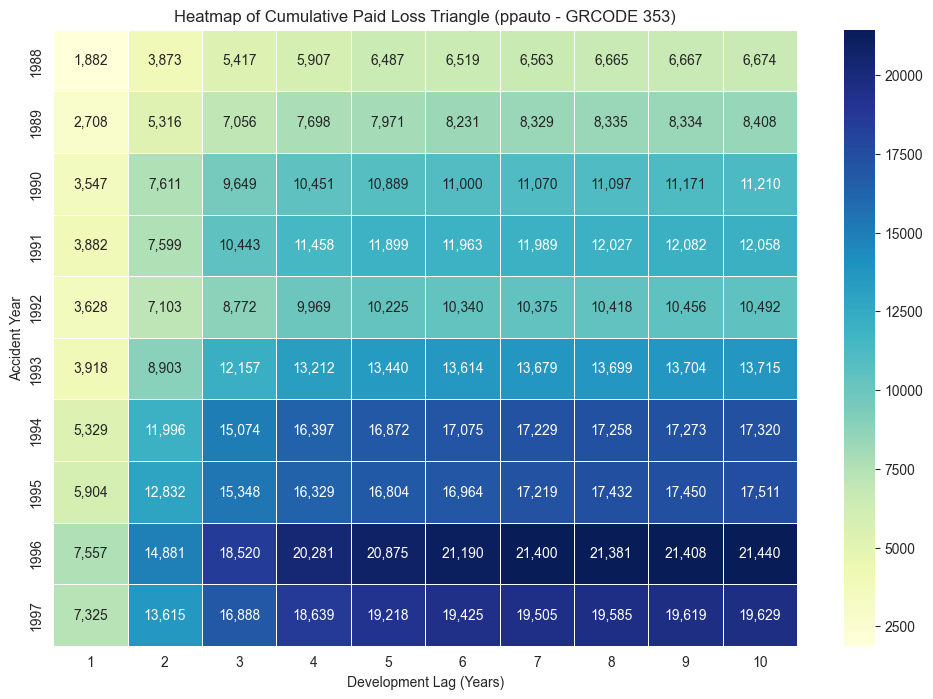

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(loss_triangle, annot=True, fmt=",.0f", cmap="YlGnBu", linewidths=.5)
plt.title('Heatmap of Cumulative Paid Loss Triangle (ppauto - GRCODE 353)')
plt.xlabel('Development Lag (Years)')
plt.ylabel('Accident Year')
plt.show()

#### Loss Development Patterns by Accident Year
This plot shows the cumulative paid loss development for each accident year. The consistency in the shape of these curves is a positive indicator for the stability assumption of the Chain-Ladder method.

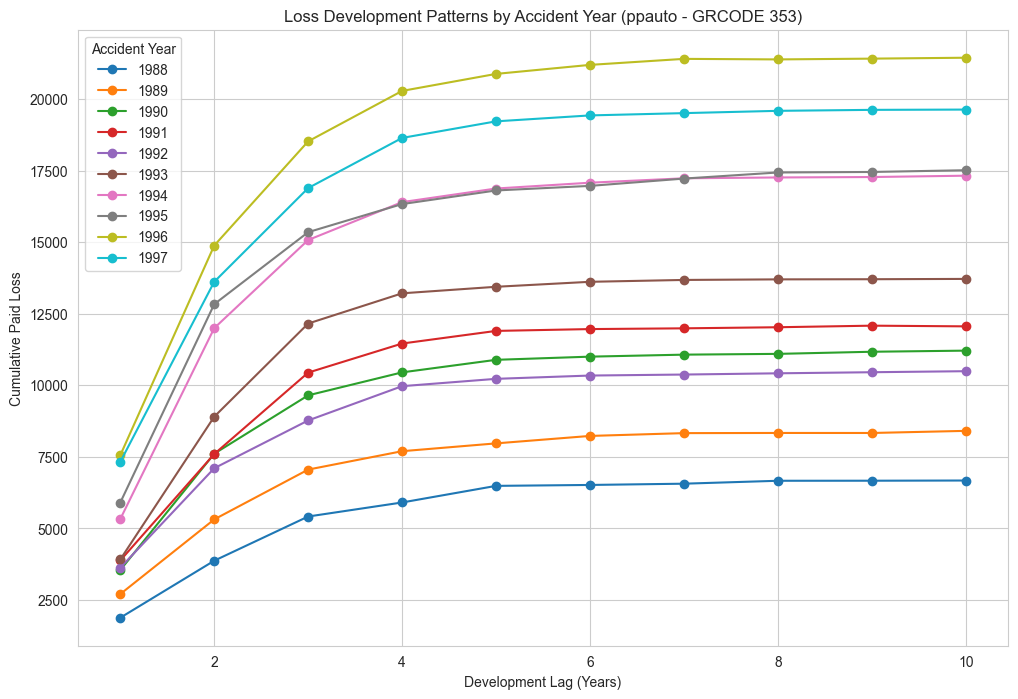

In [33]:
plt.figure(figsize=(12, 8))
for year in loss_triangle.index:
    plt.plot(loss_triangle.columns, loss_triangle.loc[year], marker='o', linestyle='-', label=year)

plt.title('Loss Development Patterns by Accident Year (ppauto - GRCODE 353)')
plt.xlabel('Development Lag (Years)')
plt.ylabel('Cumulative Paid Loss')
plt.legend(title='Accident Year')
plt.grid(True)
plt.show()

## 6. Conclusion and Next Steps

This notebook has successfully performed a thorough exploratory data analysis of the CAS Loss Reserve Database. We have systematically evaluated six different lines of business and selected the `ppauto` dataset as the most suitable candidate for our comparative study of reserving methods. A clean, homogeneous loss triangle has been constructed and is ready for the next phase of the project.

The next steps will involve:
1. Implementing the deterministic Chain-Ladder method to project ultimate losses.
2. Developing several machine learning models (e.g., Gradient Boosting, Random Forest) to predict losses on a granular level.
3. Comparing the performance, accuracy, and uncertainty of both approaches.
4. Documenting the findings and providing recommendations on the applicability of each method in a practical actuarial context.